
### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2020 Semester 1

## Assignment 1: Naive Bayes Classifiers

###### Submission deadline: 7 pm, Monday 20 Apr 2020

**Student Name(s):**    `Garvin Prathama Bulkin`

**Student ID(s):**     `927842`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1]:
# LIBRARY IMPORTS

# Importing General Tools
import numpy as np
import pandas as pd
from collections import defaultdict

# Used to hot encode nominal attributes
from sklearn.preprocessing import OneHotEncoder

# Used to plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sn

# Miscellaneous 
import math # For gaussian formula (sqrt())
import random # Random baseline (choice())
import operator # Choosing max item
from collections import Counter # zeroR baseline, counting mode class 

In [117]:
# CONSTANTS

# Number of bins for discretizing
BINS = 3

# Index for class labels
LABEL_LOC = 0

# Train/test split ratio
SPLIT_RATIO = 0.33

# Train/test seed
SEED = 1

In [115]:
# PREPROCESS FUNCTION

# Function takes in a filename, and an optional variable to enable discretization (default=OFF)
def preprocess(filename, discretize=False):
    # Reading from file to dataframe
    df = pd.read_table(filename, sep=',', header=None)
    
    # Drop missing values
    df = df[(df != '?').all(axis=1)]
    df.dropna(inplace=True)
    drop_id = []
    
    # Handle cases
    # y_index indicates the index of class labels
    # d_types represents datatypes across columns
    if(filename == 'datasets/wine.data'):
        y_index = 0
        dtypes = ['numeric']*13
    elif(filename == 'datasets/wdbc.data'):
        y_index = 1
        dtypes = ['numeric']*31
    elif(filename == 'datasets/mushroom.data'):
        y_index = 0
        dtypes = ['nominal']*22
        drop_id = 1
    elif(filename == 'datasets/car.data'):
        # Indicate ordering of categories
        ord_categories = [['v-high', 'high', 'med', 'low'],['v-high', 'high', 'med', 'low'],
                          ['2', '3', '4', '5-more'],['2', '4', 'more'],
                          ['small', 'med', 'big'],['low', 'med', 'high']]
        y_index = 6
        dtypes = ['ordinal']*6
    elif(filename == 'datasets/adult.data'):
        y_index = 14
        dtypes = ['numeric', 'nominal','numeric', 'ordinal', 'ordinal',
                  'nominal', 'nominal', 'nominal', 'nominal', 'nominal',
                  'numeric', 'numeric', 'numeric', 'nominal']
        drop_id = 1
    else:
        y_index = len(df.columns)-1
        types = df.dtypes
    
    # Initialize dataframe for attributes
    x_df = pd.DataFrame()
    
    # Handling different types:
    i = 0
    for label in df.columns:
        if(label != y_index):
            # Handle NUMERICAL data (discretizing with equal width bins)
            if(discretize and dtypes[i] == 'numeric'):
                x_df[label] = pd.cut(df[label], BINS, labels=range(0,BINS))
            else:
                x_df[label] = df[label]
            i+=1
            
    # Resetting column indexes
    x_df.columns = range(x_df.shape[1])
    
    #Handle ordinal values
    # Enumerating ordinal datatypes to create numerical order
    ordinal_idx = [i for i, x in enumerate(dtypes) if x == "ordinal"]
    for index in ordinal_idx:
        x_df[index] = x_df[index].astype('category').cat.codes

    # Handle nominal values
    # Hot encoding:
#     nominal_idx = [i for i, x in enumerate(dtypes) if x == "nominal"]
#     x_df = pd.get_dummies(x_df, columns=nominal_idx)
    
    # Concatenate class label column with attribute dataframe
    result= pd.concat([df[y_index].to_frame(),x_df], axis=1, ignore_index=True)
    
    # Return a numpy array of the dataframe and datatype of each column
    return result.to_numpy(), dtypes

In [105]:
# TRAIN FUNCTION

# Function takes in array of data and its types, calculates prior probabilities and likelihoods 
# from the training data to build a Naive Bayes model. Model is returned in the form of priors and likelihoods.
def train(data,dtypes):
    # Calculate class priors
    class_priors = get_priors(data)
    
    # Calculate likelihoods of p(a|c)
    likelihoods = get_likelihoods(data, class_priors)
    
    # Calculate gaussian probabilities
    gauss_prob = get_stats(data,dtypes)
    return (class_priors, likelihoods, gauss_prob)

# Function takes in np.array as input and returns the prior probabilities for each class
def get_priors(data):
    # Use defaultdict to count occurence of each class label
    priors = defaultdict(float)
    
    # Iterate through instances and calculates the priors after iteration
    for instance in data:
        priors[instance[LABEL_LOC]] += 1
    for label in priors.keys():
        priors[label] = priors[label] / np.shape(data)[0]
    return priors

# Function takes in training data and prior probabilities and returns the likelihood of each class
# and the attributes.
# NOTE: Used epsilon smoothing with epsilon = 1/N
def get_likelihoods(data, priors):
    EPSILON = 1/np.shape(data)[0]
    
    # Use defaultdict to keep probabilities, default value is epsilon used as smoothing method
    likelihoods = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda:EPSILON)))
    
    # Iterates through each column and calculates its likelihood for each class
    for column in range(1,np.shape(data)[1]):
        for instance in data:
            likelihoods[instance[LABEL_LOC]][column][instance[column]] += 1
    for label in priors.keys():
        for column in range(1,np.shape(data)[1]):
            for attribute in likelihoods[label][column].keys():
                likelihoods[label][column][attribute] /= (priors[label] * np.shape(data)[0])
    return likelihoods

# Function specifically used for Gaussian Bayes, it takes in training data and its datatypes and returns a
# dictionary of mean and standard deviations for each numerical column
def get_stats(data,dtypes):
    EPSILON = 1/np.shape(data)[0]
    separated = defaultdict(list)
    for instance in data:
        separated[instance[LABEL_LOC]].append(instance)
        

    stats = defaultdict(lambda: defaultdict(lambda:defaultdict(lambda:EPSILON)))
    for column_idx in range(1,np.shape(data)[1]):
        if(dtypes[column_idx-1] == 'numeric'):
            for class_label in separated.keys():
                column = np.array(separated[class_label])[:,column_idx]
                stats[class_label][column_idx]['mu'] = np.mean(column)
                stats[class_label][column_idx]['std'] = np.std(column)
    return stats

# Returns the probability based on the gaussian bayes formula
def get_gauss_probability(x,mean,std):
    first_term = 1/(std*(math.sqrt(2*math.pi)))
    exponent = math.exp((-1/2)*(((x-mean)/std)**2))
    return first_term * exponent

# Helper function that returns all class labels for a dataset
def get_class_labels(data):
    return np.unique(data[:,LABEL_LOC])

In [106]:
# PREDICT FUNCTION

# Function takes in a test set, training set, and its datatypes, and returns an array of predictions using
# the Naive Bayes Model
def predict(test,training_set,dtypes,gaussian=True):
    # Retrieves Model probabilities using train()
    priors = get_priors(train)
    likelihoods = get_likelihoods(train,priors)
    gauss_prob = get_stats(train,dtypes)
    
    # Iterating trough each instance and making prediction based on the Naive Bayes model
    result = []
    for instance in test:
        result.append(predict_instance(instance,training_set,priors,likelihoods,dtypes,gauss_prob,gaussian))
        
    # Return array of predictions
    return np.array(result)

# Function takes in test instance, and the probabilities from the Naive Bayes model to predict label for the instance
def predict_instance(instance,data,priors,likelihoods,gauss_prob,dtypes,gaussian=True):
    # Getting class label to initialize probabilities
    class_labels = get_class_labels(data)
    probabilities = defaultdict(lambda:1.0)
    
    # Initializing each class probability using prior probabilities
    i = 0
    for label in class_labels:
        if(dtypes[i]!='numerical' and gaussian):
            probabilities[label] = priors[label]
        i += 1      
    
    # Calculating the probability for each class for the given instance
    for column in range(1,len(instance)):
        for label in class_labels:
            # If using gaussian NB:
            if(gaussian and dtypes[column] == 'numerical'):
                probabilities[label] *= get_gauss_probability(instance[column], 
                                                              gauss_prob[label][column]['mu'], 
                                                                  gauss_prob[label][column]['std'])
            # Non-gaussian NB:
            else:
                probabilities[label] *= likelihoods[label][column][instance[column]]
                
    # Return the class with highest probability
    return max(probabilities.items(), key=operator.itemgetter(1))[0]

# Function splits input data to train and test sets
def split_instances(data):
    # Shuffles data and splits them based on SPLIT_RATIO
    np.random.seed(SEED)
    np.random.shuffle(data)
    cutoff = int(data.shape[0] * SPLIT_RATIO)
    test, training =data[:cutoff,:], data[cutoff:,:]
    return test, training

In [107]:
# EVALUATE FUNCTION

# Function takes in a test set and the array containing prediction of class labels, and prints relevant metrics to
# measure the effectiveness of the model
def evaluate(test_set, prediction):
    print("Accuracy: {:.0%}".format(get_accuracy(test, prediction)))
    print("Error-rate: {:.0%}".format(get_error_rate(test, prediction)))
    print("Precision: {:.0%}".format(get_precision(test, prediction)))
    print("Recall: {:.0%}".format(get_recall(test, prediction)))
    print("F1 Score: {:.2f}".format(get_f1(test, prediction)))
    
    # F1 Score not used for multiclass datasets
    if(len(get_class_labels(test_set)) > 2):
        get_confusion_matrix(test,prediction)
    return

# Returns the accuracy of the model
def get_accuracy(test_set, prediction_result):
    return count_correct_labels(test_set, prediction_result)/np.shape(test_set)[0]

# Returns the error rate of the model
def get_error_rate(test_set, prediction_result):
    return 1 - get_accuracy(test_set,prediction_result)

# Returns the precision of the model using using true positives and false positives
def get_precision(test_set, prediction_result):
    class_labels = get_class_labels(test_set)
    precisions = []    
    
    for label in class_labels:
        tp = count_true_positives(test_set, prediction_result,label)
        fp = count_false_positives(test_set, prediction_result,label)
        
        if(len(class_labels) <= 2):
            return tp/(tp+fp)
        precisions.append(tp/(tp+fp))
    
    return np.mean(np.array(precisions))

# Returns the recall rate
def get_recall(test_set, prediction_result):
    class_labels = get_class_labels(test_set)
    recalls = []    
    
    # Handling multiclass recall
    for label in class_labels:
        tp = count_true_positives(test_set, prediction_result,label)
        # Counts error by subtracting total instances by total correct labels
        errors = np.shape(test_set)[0] - count_correct_labels(test_set, prediction_result)
        fn = errors - count_false_positives(test_set, prediction_result,label)
        
        if(len(class_labels) <= 2):
            return (tp/(tp+fn))
        
        recalls.append(tp/(tp+fn))

    return np.mean(np.array(recalls))

# Returns the F1 score
def get_f1(test_set, prediction_result):
    precision = get_precision(test_set,prediction_result)
    recall = get_recall(test_set,prediction_result)
    return (2*precision*recall)/(precision+recall)

# Function counts the number of correctly predicted labels
def count_correct_labels(test_set, prediction_result):
    return sum(x == y for x, y in zip(test_set[:,0], prediction_result))

# Function counts the number of true positives in the prediction
def count_true_positives(test_set, prediction_result,positive_label):
    count = 0
    for i in range(0,len(prediction_result)):
        if(test[:,0][i] == prediction_result[i] == positive_label):
            count+=1
    return count

# Function counts the number of false positives in the prediction
def count_false_positives(test_set, prediction_result,positive_label):
    count = 0
    for i in range(0,len(prediction_result)):
        if((test[:,0][i] != prediction_result[i]) and (prediction_result[i] == positive_label)):
            count+=1
    return count

# NOTE: Used for multiclass evaluation
# Function outputs the confusion matrix for a given test set and model predictions
def get_confusion_matrix(test_set,prediction_result):
    # Class labels for labelling the confusion matrix
    class_labels = get_class_labels(test_set)
    
    # Iterate through test set and predictions to count correct labels for each class
    count_correct = defaultdict(float)
    count_instance = defaultdict(int)
    for actual,prediction in zip(test_set[:,0], prediction_result):
        if(actual == prediction):
            count_correct[actual] += 1
        count_instance[actual] += 1
    
    # Calculates the accuracy for each class
    for key in count_correct.keys():
        count_correct[key] /= count_instance[key]
        
    # Creating & plotting the confusion matrix using seaborn heatmap
    matrix = np.diag(list(count_correct.values()))
    df_cm = pd.DataFrame(matrix, index = class_labels,columns = class_labels)
    plt.figure(figsize = (11,8))
    sn.heatmap(df_cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    return
    

## Questions 


If you are in a group of 1, you will respond to question (1), and **one** other of your choosing (two responses in total).

If you are in a group of 2, you will respond to question (1) and question (2), and **two** others of your choosing (four responses in total). 

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions in respond to the question, but your formal answer should be added to a separate file.

### Q1
Try discretising the numeric attributes in these datasets and treating them as discrete variables in the na¨ıve Bayes classifier. You can use a discretisation method of your choice and group the numeric values into any number of levels (but around 3 to 5 levels would probably be a good starting point). Does discretizing the variables improve classification performance, compared to the Gaussian na¨ıve Bayes approach? Why or why not?

Wine Dataset:

Gaussian Naive Bayes:
Accuracy: 72%
Error-rate: 28%
Precision: 73%
Recall: 56%
F1 Score: 0.63

Naive Bayes:
Accuracy: 95%
Error-rate: 5%
Precision: 94%
Recall: 90%
F1 Score: 0.92


Text(0.5, 1, 'Naive Bayes (discretized numeric att.) Confusion Matrix')

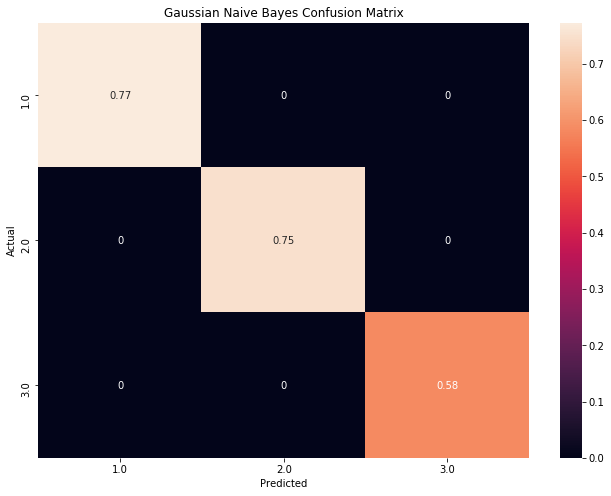

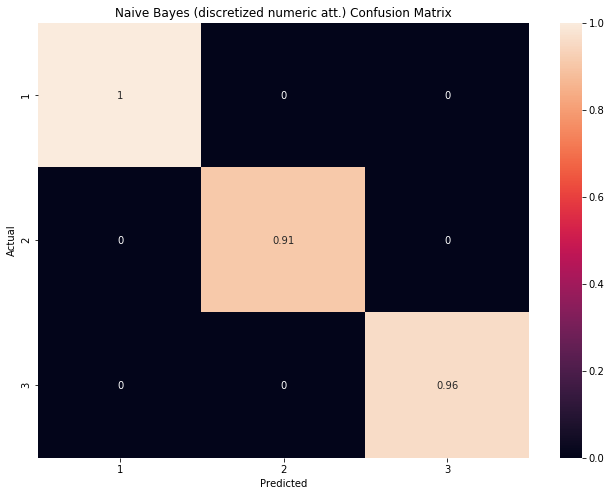

In [118]:
# Gaussian Naive Bayes
print("Wine Dataset:\n")
print("Gaussian Naive Bayes:")
data, types= preprocess('datasets/wine.data',discretize=False)
test,train = split_instances(data)
prediction = predict(test,train,types,gaussian=True)
random_prediction = random_baseline(test)
evaluate(test, prediction)
plt.title("Gaussian Naive Bayes Confusion Matrix")

# Naive Bayes with discretized numeric variables
print("\nNaive Bayes:")
data, types= preprocess('datasets/wine.data',discretize=True)
test,train = split_instances(data)
prediction = predict(test,train,types, gaussian=False)
random_prediction = random_baseline(test)
evaluate(test, prediction)
plt.title("Naive Bayes (discretized numeric att.) Confusion Matrix")

In [109]:
# Gaussian Naive Bayes
print("WDBC Dataset:\n")
print("Gaussian Naive Bayes:")
data, types= preprocess('datasets/wdbc.data',discretize=False)
test,train = split_instances(data)
prediction = predict(test,train,types,gaussian=True)
random_prediction = random_baseline(test)
evaluate(test, prediction)

# Naive Bayes with discretized numeric variables
print("\nNaive Bayes:")
data, types= preprocess('datasets/wdbc.data',discretize=True)
test,train = split_instances(data)
prediction = predict(test,train,types, gaussian=False)
random_prediction = random_baseline(test)
evaluate(test, prediction)

WDBC Dataset:

Gaussian Naive Bayes:
Accuracy: 71%
Error-rate: 29%
Precision: 77%
Recall: 80%
F1 Score: 0.78

Naive Bayes:
Accuracy: 96%
Error-rate: 4%
Precision: 96%
Recall: 98%
F1 Score: 0.97


In [116]:
# Gaussian Naive Bayes
print("Adult Dataset:\n")
print("Gaussian Naive Bayes:")
data, types= preprocess('datasets/adult.data',discretize=False)
test,train = split_instances(data)
prediction = predict(test,train,types,gaussian=True)
random_prediction = random_baseline(test)
evaluate(test, prediction)

# Naive Bayes with discretized numeric variables
print("\nNaive Bayes:")
data, types= preprocess('datasets/adult.data',discretize=True)
test,train = split_instances(data)
prediction = predict(test,train,types, gaussian=False)
random_prediction = random_baseline(test)
evaluate(test, prediction)

Adult Dataset:

Gaussian Naive Bayes:
Accuracy: 84%
Error-rate: 16%
Precision: 93%
Recall: 85%
F1 Score: 0.89

Naive Bayes:
Accuracy: 78%
Error-rate: 22%
Precision: 94%
Recall: 76%
F1 Score: 0.84


### Q2
Implement a baseline model (e.g., random or 0R) and compare the performance of the na¨ıve Bayes classifier to this baseline on multiple datasets. Discuss why the baseline performance varies across datasets, and to what extent the na¨ıve Bayes classifier improves on the baseline performance.

In [111]:
# Random baseline model that outputs random predictions
def random_baseline(test_set):
    class_labels = get_class_labels(test_set)
    return [random.choice(class_labels) for i in range(0,len(test_set))]

# Zero R baseline model that outputs the mode of the test set
def zeroR_baseline(test_set):
    class_labels = get_class_labels(test_set)
    return [Counter(test_set[:,0]).most_common(1)[0][0]]*len(test_set)

Wine Dataset

Naive Bayes:
Accuracy: 97%
Error-rate: 3%
Precision: 97%
Recall: 92%
F1 Score: 0.95

Random Baseline:
Accuracy: 36%
Error-rate: 64%
Precision: 38%
Recall: 22%
F1 Score: 0.28


Text(0.5, 1, 'Random Baseline Confusion Matrix')

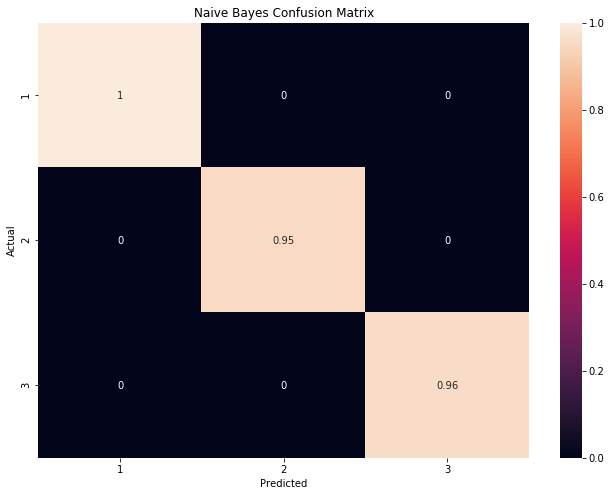

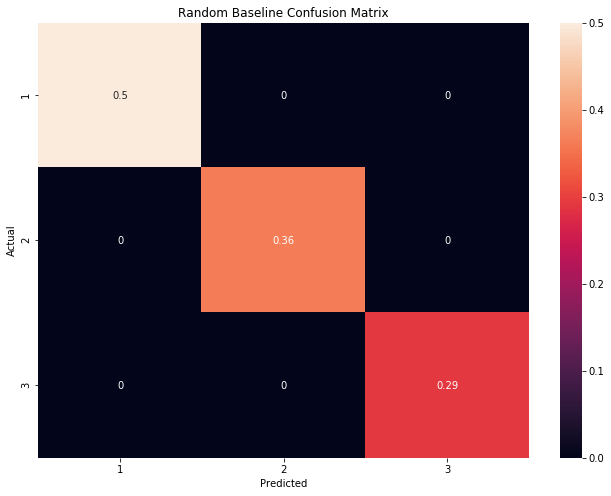

In [112]:
# Wine Dataset
data, types= preprocess('datasets/wine.data',discretize=True)
test,train = split_instances(data)
prediction = predict(test,train,types)
random_prediction = random_baseline(test)

# Evaluation
print("Wine Dataset\n")
print("Naive Bayes:")
evaluate(test, prediction)
plt.title("Naive Bayes Confusion Matrix")

# Evaluation of random baseline
print("\nRandom Baseline:")
evaluate(test, random_prediction)
plt.title("Random Baseline Confusion Matrix")

In [113]:
# Mushroom Dataset
data, types= preprocess('datasets/mushroom.data',True)
test,train = split_instances(data)
prediction = predict(test,train,types)
random_prediction = random_baseline(test)
# zeroR_prediction = zeroR_baseline(test)

print("Mushroom Dataset\n")
print("Naive Bayes:")
evaluate(test, prediction)


print("\nRandom Baseline:")
evaluate(test, random_prediction)

Mushroom Dataset

Naive Bayes:
Accuracy: 98%
Error-rate: 2%
Precision: 97%
Recall: 100%
F1 Score: 0.98

Random Baseline:
Accuracy: 50%
Error-rate: 50%
Precision: 63%
Recall: 47%
F1 Score: 0.54


Car Dataset

Naive Bayes:
Accuracy: 87%
Error-rate: 13%
Precision: 80%
Recall: 46%
F1 Score: 0.58

Random Baseline:
Accuracy: 26%
Error-rate: 74%
Precision: 26%
Recall: 9%
F1 Score: 0.13


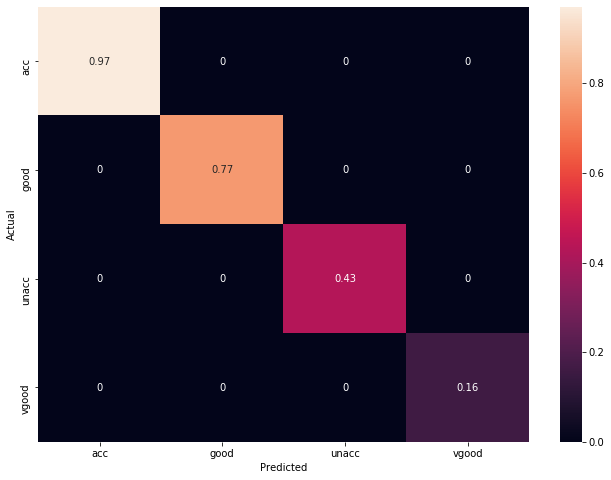

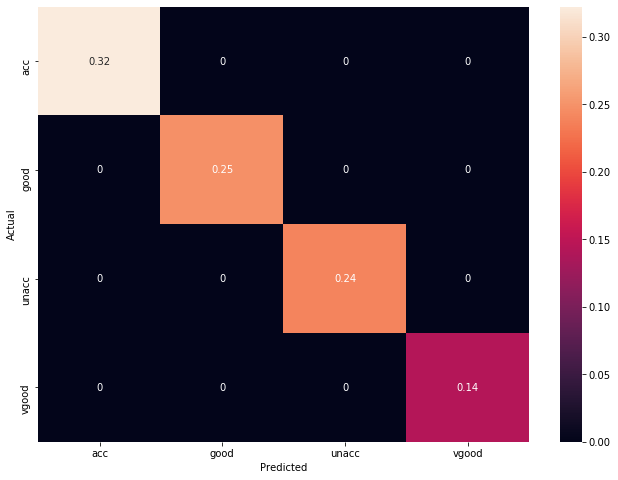

In [70]:
# Car Dataset
data, types= preprocess('datasets/car.data',True)
test,train = split_instances(data)
prediction = predict(test,train,types)
random_prediction = random_baseline(test)
# zeroR_prediction = zeroR_baseline(test)

print("Car Dataset\n")
print("Naive Bayes:")
evaluate(test, prediction)


print("\nRandom Baseline:")
evaluate(test, random_prediction)

In [114]:
# Adult Dataset
data, types= preprocess('datasets/adult.data',True)
test,train = split_instances(data)
prediction = predict(test,train,types)
random_prediction = random_baseline(test)
# zeroR_prediction = zeroR_baseline(test)

print("Adult Dataset\n")
print("Naive Bayes:")
evaluate(test, prediction)


print("\nRandom Baseline:")
evaluate(test, random_prediction)

Wine Dataset

Naive Bayes:
Accuracy: 81%
Error-rate: 19%
Precision: 92%
Recall: 83%
F1 Score: 0.87

Random Baseline:
Accuracy: 49%
Error-rate: 51%
Precision: 74%
Recall: 49%
F1 Score: 0.59


### Q3
Since it’s difficult to model the probabilities of ordinal data, ordinal attributes are often treated as either nominal variables or numeric variables. Compare these strategies on the ordinal datasets provided. Deterimine which approach gives higher classification accuracy and discuss why.

### Q4
Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. Implement a hold–out or cross–validation evaluation strategy (you should implement this yourself and do not simply call existing implementations from `scikit-learn`). How does your estimate of effectiveness change, compared to testing on the training data? Explain why. (The result might surprise you!)

### Q5
Implement one of the advanced smoothing regimes (add-k, Good-Turing). Does changing the smoothing regime (or indeed, not smoothing at all) affect the effectiveness of the na¨ıve Bayes classifier? Explain why, or why not.

### Q6
The Gaussian na¨ıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in these datasets? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the NB classifier’s predictions.